# Data Exploration and Dataset re-build 

In [1]:
import os
from query_tool import M100DataClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
from datetime import timedelta

plt.style.use("seaborn-v0_8")

DATASET_FOLDER = "./dataset/"
DATASET_FOLDER_ORIGINAL = DATASET_FOLDER + "original/"
DATASET_FOLDER_REBUILD = DATASET_FOLDER + "rebuild/"

DISPLAY_GRAPHS = True

YEAR = 2022
MONTH = 9

date_dataset = datetime(YEAR, MONTH, 1)

dataset_rebuild_path = DATASET_FOLDER_REBUILD + date_dataset.strftime("%y-%m")
os.makedirs(dataset_rebuild_path, exist_ok=True)


dataset_path = (
    DATASET_FOLDER_ORIGINAL + date_dataset.strftime("%y-%m") + "/year_month=" + date_dataset.strftime("%y-%m")
)
dataset_path

'./dataset/original/22-09/year_month=22-09'

In [2]:
client = M100DataClient(dataset_path)

In [3]:
# Create array of days for graphs
# [2022-09-01, 2022-09-02, 2022-09-03, ...]
xticks_days = [
    date_dataset.replace(day=i).strftime("%Y-%m-%d")
    for i in range(1, calendar.monthrange(date_dataset.year, date_dataset.month)[1] + 1)
]

In [4]:
# Detect non numerical features
filtered_dict = {
    key: value
    for key, value in client.dtype_per_metric.items()
    if not any(t in str(value) for t in ["float", "int", "double"])
}
filtered_dict

{'machine_type': DataType(string),
 'gexec': DataType(string),
 'os_name': DataType(string),
 'os_release': DataType(string),
 'Prototype': DataType(string),
 'address': DataType(string),
 'Gateway': DataType(string),
 'job_info_marconi100': None}

In [5]:
def metrics_description(plugin):
    print("Plugin: '{}'".format(plugin))
    for metric in client.metrics_per_plugin[plugin]:
        print("metric: '{}'".format(metric))
        print("\tdtype:", client.dtype_per_metric[metric])
        print("\ttags:", client.tags_per_metric[metric])
    print("----------------------------------------------------------------")
    print(
        "NON NUMERICAL METRICS:",
        list(metric for metric in client.metrics_per_plugin[plugin] if metric in filtered_dict.keys()),
    )

# Nodes with the most data available 

In [6]:
%%script false --no-raise-error

highest_nodeID = 1162
nodes_rows = pd.DataFrame({"rows": [0] * highest_nodeID}, dtype=int)
fill_na_rows = pd.DataFrame({"node": range(0, highest_nodeID + 1, 1)}, dtype=int)

for plugin, metrics in all_metrics.items():
    for met in metrics:
        # Create dataset with {nodeID, number of rows of the metric}
        results = (
            client.query(metrics=[met], columns=["node"])
            .groupby("node", observed=False)
            .size()
            .reset_index(name="rows")
            .astype({"node": int})
            .sort_values("node")
            .reset_index(drop=True)
        )
        results = pd.merge(fill_na_rows, results, on="node", how="left")
        nodes_rows["rows"] += results["rows"].fillna(0)

display(
    nodes_rows.sort_values(by="rows", ascending=False)
    .head(10)
    .style.set_caption("Nodes with most data available")
)

# # Results:
# 3	    28246529
# 1	    28246382
# 2	    28243448
# 0	    28219495
# 880	27026042
# 703	27023216
# 334	27020755
# 41	27011895
# 961	27008536
# 585	27003582

# Nodes with most Nagios anomalies

In [7]:
%%script false --no-raise-error
results = (
    client.query_plugins(plugins=["nagios"], columns=["node", "value"])
    .query("value in [1,2,3]")
    .groupby("node", observed=False)
    .size()
    .reset_index(name="rows")
    .astype({"node": int})
    .sort_values("node")
    .reset_index(drop=True)
)

results = nodes_rows.iloc[
    results.sort_values(by="rows", ascending=False).iloc[0:10, 0].values, :
]

display(
    results.sort_values(by="rows", ascending=False)
    .head(10)
    .style.set_caption("Nodes with most data available")
)

# Results
# 19	26281005
# 949	25556767
# 298	25544516
# 322	24589350
# 38	24106684
# 335	24094853
# 10	23496599
# 1007	52237
# 1008	10668
# 1002	5334

In [8]:
# good examples: 10, 38, 335
NODE_SELECTED = "10"

In [9]:
%reset_selective -f ^date_dataset$
%reset_selective -f ^YEAR$
%reset_selective -f ^MONTH$
%reset_selective -f ^DATASET_FOLDER$
%reset_selective -f ^plugins$

# Nagios

In [10]:
metrics_description("nagios")

Plugin: 'nagios'
metric: 'state'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'description', 'host_group', 'nagiosdrained', 'node', 'state_type']
----------------------------------------------------------------
NON NUMERICAL METRICS: []


In [11]:
df_nagios = client.query_plugins(plugins="nagios", node=NODE_SELECTED).sort_values(by="timestamp", ascending=True)

df_nagios.info()
display(df_nagios.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 40005 entries, 0 to 25841
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   host_group     40005 non-null  category           
 1   plugin         40005 non-null  category           
 2   state_type     40005 non-null  string             
 3   description    40005 non-null  category           
 4   year_month     0 non-null      category           
 5   value          40005 non-null  Int32              
 6   timestamp      40005 non-null  datetime64[ms, UTC]
 7   nagiosdrained  40005 non-null  string             
 8   node           40005 non-null  category           
 9   metric         40005 non-null  category           
dtypes: Int32(1), category(6), datetime64[ms, UTC](1), string(2)
memory usage: 1.8 MB


,host_group,plugin,state_type,description,year_month,value,timestamp,nagiosdrained,node,metric
0,"idmtest,compute",nagios_pub,1,alive::ping,NaN,0,2022-09-01 00:00:00+00:00,0,10,state
176,"idmtest,compute",nagios_pub,1,batchs::client,NaN,0,2022-09-01 00:00:00+00:00,0,10,state
264,"idmtest,compute",nagios_pub,1,filesys::eurofusion::mount,NaN,0,2022-09-01 00:00:00+00:00,0,10,state


In [12]:
# Keep only useful columns
df_nagios = df_nagios[["description", "value", "timestamp", "nagiosdrained"]]
descriptions = df_nagios["description"].sort_values().unique()

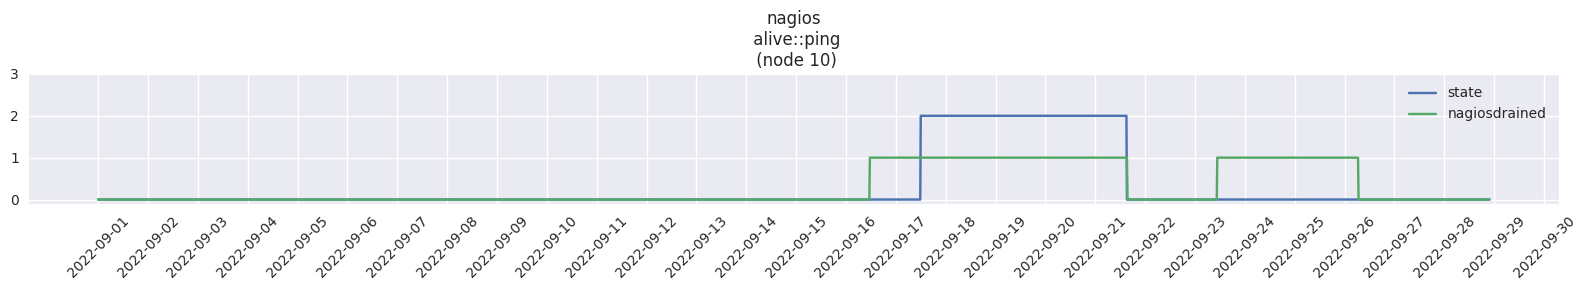

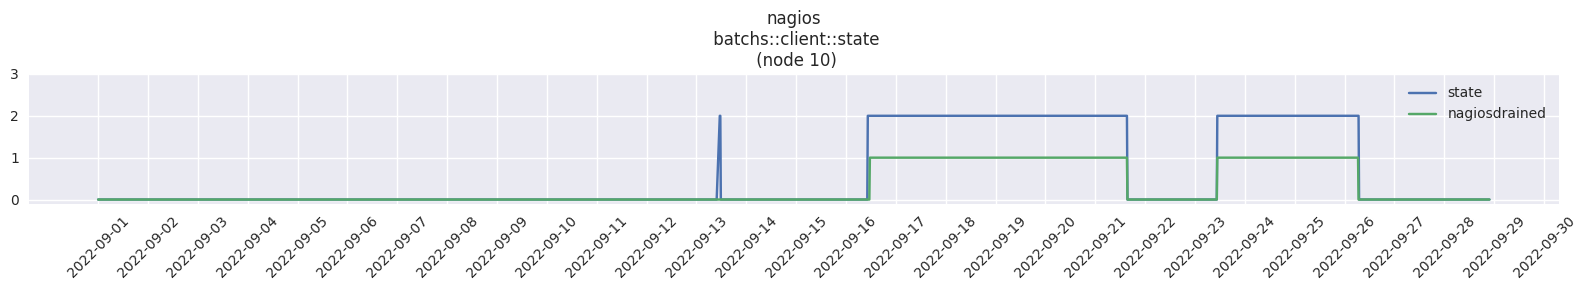

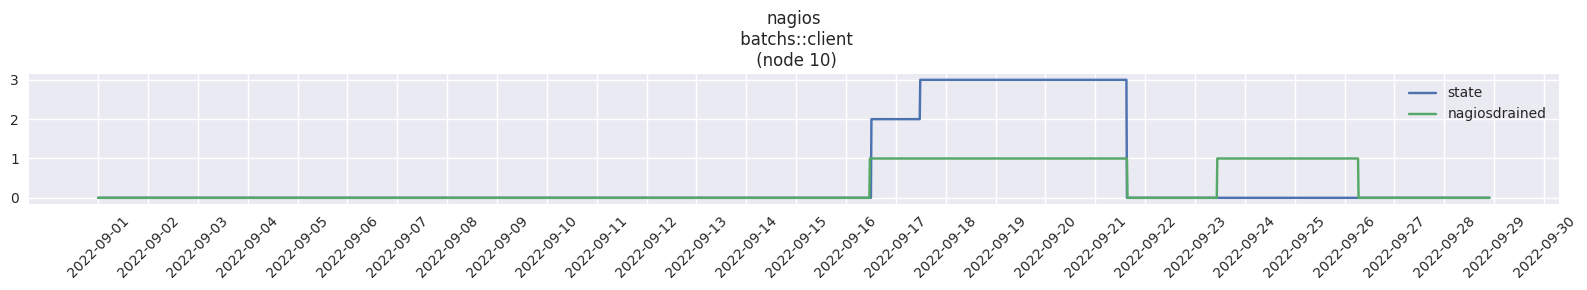

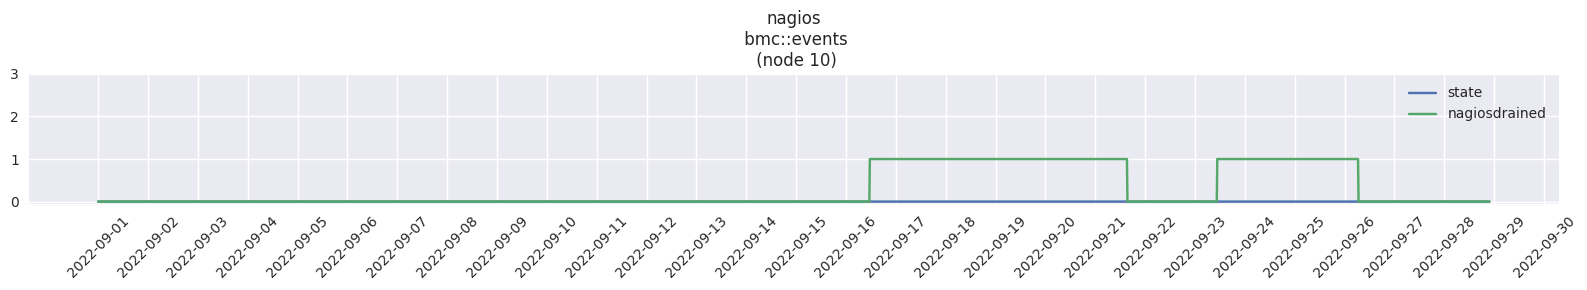

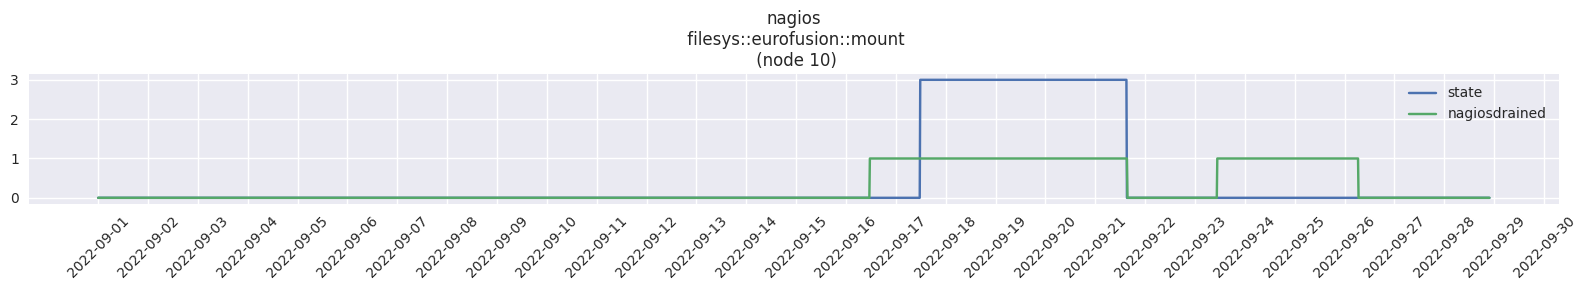

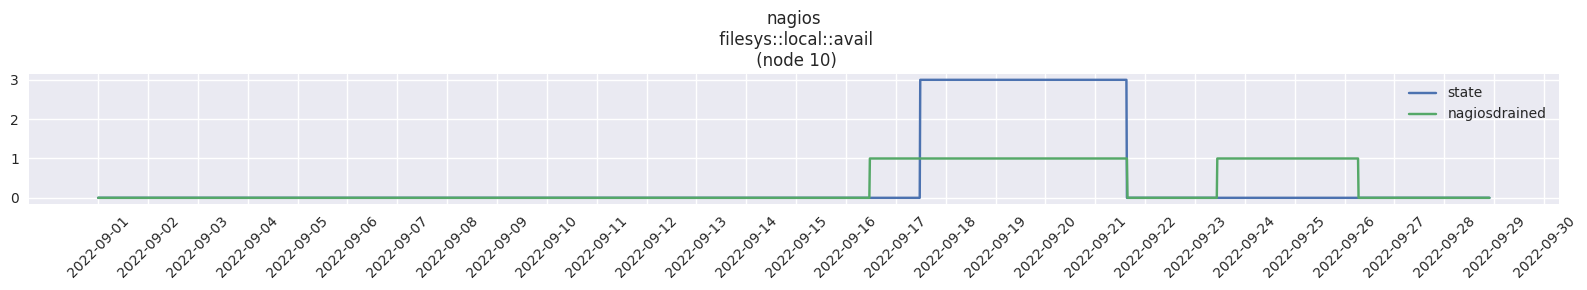

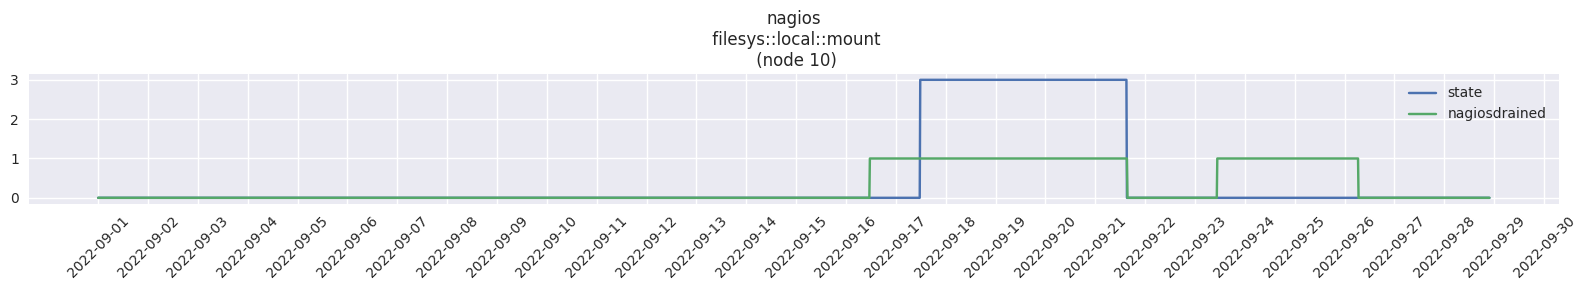

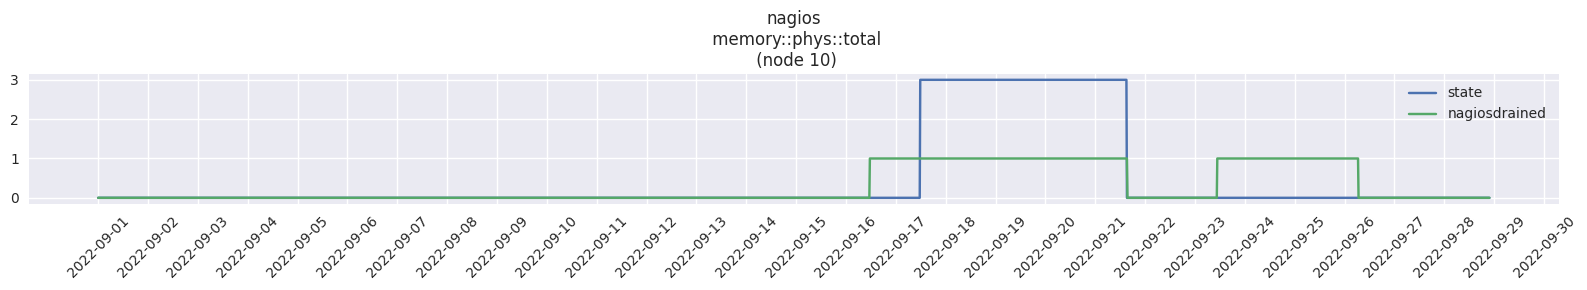

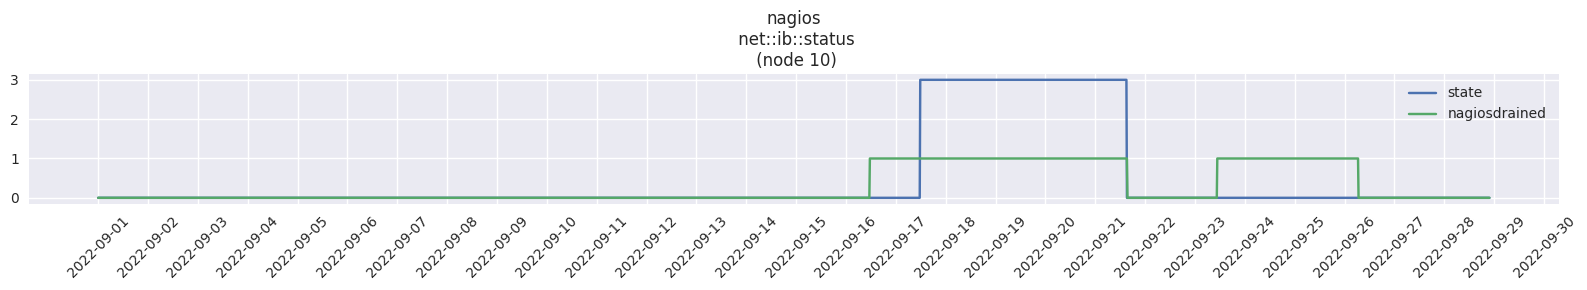

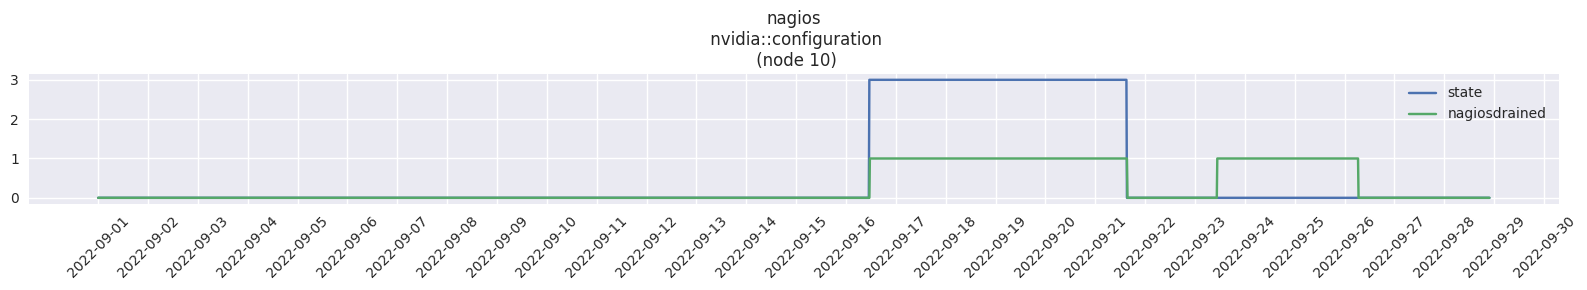

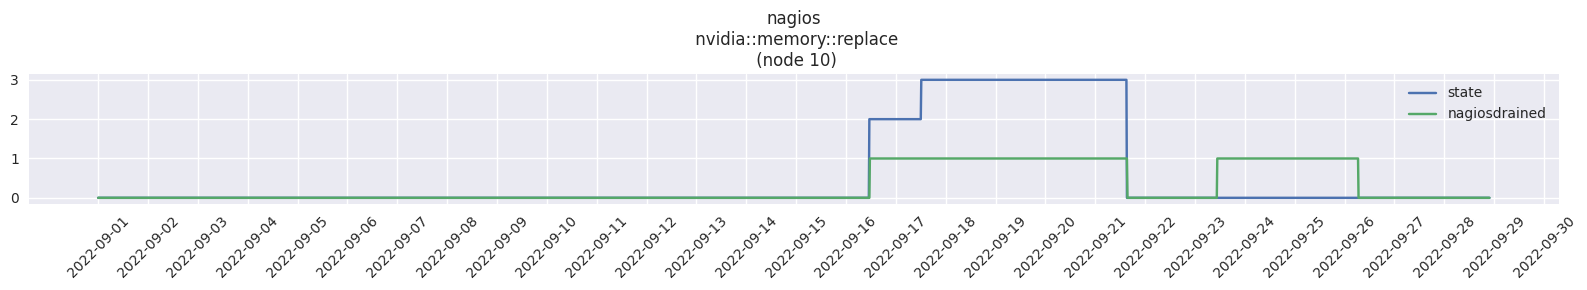

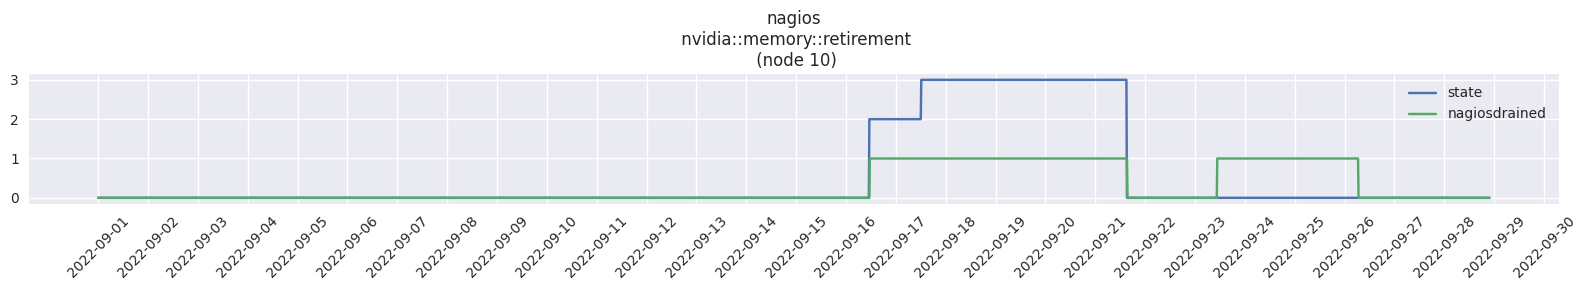

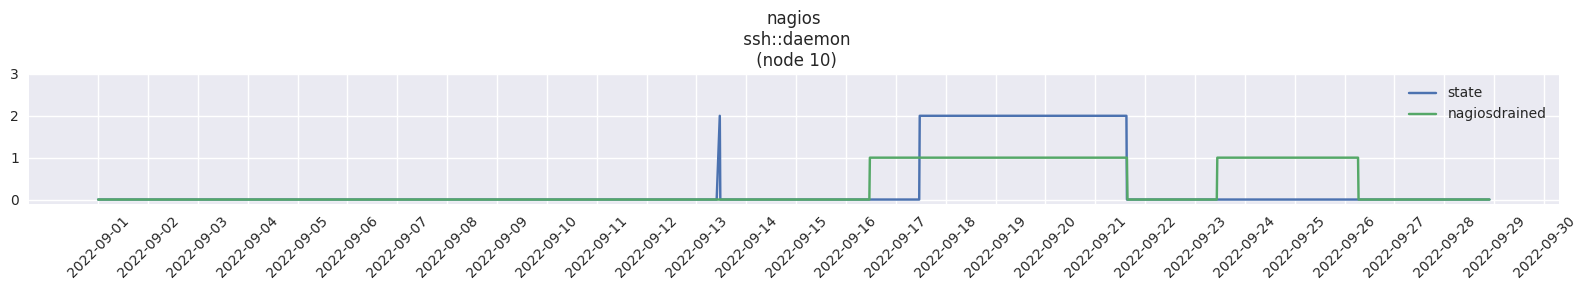

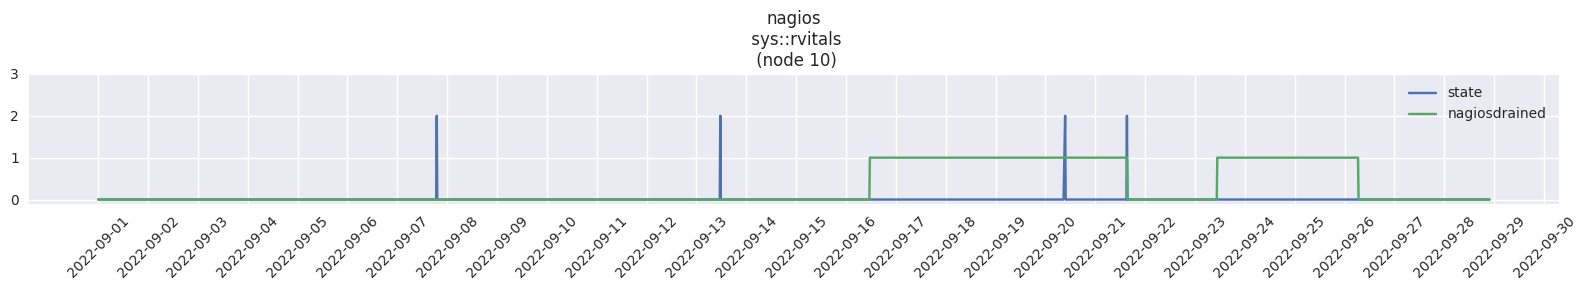

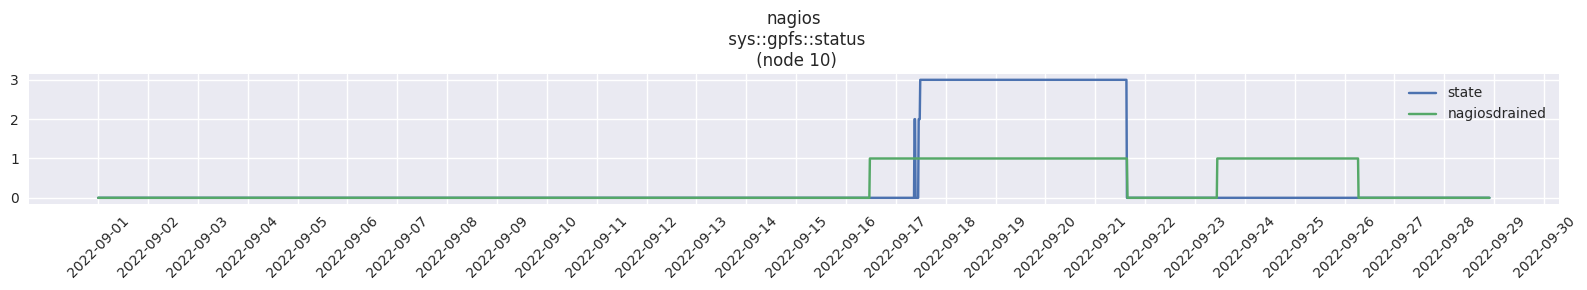

In [13]:
# Display graphs
if DISPLAY_GRAPHS:
    for descr in descriptions:
        _, axes = plt.subplots(figsize=(16, 3))
        df_nagios_plot = df_nagios.loc[df_nagios["description"] == descr][["timestamp", "value", "nagiosdrained"]]
        axes.plot(df_nagios_plot["timestamp"], df_nagios_plot["value"], label="state")
        axes.plot(df_nagios_plot["timestamp"], df_nagios_plot["nagiosdrained"].astype(int), label="nagiosdrained")
        axes.set_title("{}\n {}\n (node {})".format("nagios", descr, NODE_SELECTED))
        axes.legend()
        axes.set_xticks(xticks_days), axes.set_yticks([0, 1, 2, 3])
        axes.tick_params(axis="x", labelrotation=45)
        plt.tight_layout()
        plt.show()

## Verifications

In [14]:
# Verify that the timestamps of all the descriptions are equal
is_equal_descr = True
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["timestamp"]
for descr in descriptions[1:]:
    is_equal_descr = (
        is_equal_descr
        and (df_temp == df_nagios.loc[df_nagios["description"] == descr].reset_index()["timestamp"]).all()
    )
if not is_equal_descr:
    raise Exception("Not all description timestamps are equal")

In [15]:
# Verify that "nagiosdrained" of all the descriptions are equal
is_equal_nagios_drained = True
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["nagiosdrained"]
for descr in descriptions:
    is_equal_nagios_drained = (
        is_equal_nagios_drained
        and (df_temp == df_nagios.loc[df_nagios["description"] == descr].reset_index()["nagiosdrained"]).all()
    )

if not is_equal_nagios_drained:
    raise Exception("Not all description nagiosdrained are equal")

In [16]:
# Verify that the timestamps are equally spaced and that there are no time holes.
# Take only the timestamps of one description since they're all equal

TIME_DELTA_MINS = 15


def check_timestamps(timestamps):
    ts_temp = None
    for ts in timestamps:
        if ts_temp != None:
            if ts - ts_temp != timedelta(minutes=TIME_DELTA_MINS):
                missing_intervals = (ts - ts_temp) // timedelta(minutes=TIME_DELTA_MINS) - 1
                print(
                    "There is a time hole of {} timestamps, between these *present* timestamps: \n {}\n {}\n".format(
                        missing_intervals, ts_temp, ts
                    )
                )
        ts_temp = ts


df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["timestamp"]
check_timestamps(df_temp)

There is a time hole of 3 timestamps, between these *present* timestamps: 
 2022-09-12 20:30:00+00:00
 2022-09-12 21:30:00+00:00

There is a time hole of 2 timestamps, between these *present* timestamps: 
 2022-09-13 08:15:00+00:00
 2022-09-13 09:00:00+00:00

There is a time hole of 5 timestamps, between these *present* timestamps: 
 2022-09-13 09:45:00+00:00
 2022-09-13 11:15:00+00:00

There is a time hole of 1 timestamps, between these *present* timestamps: 
 2022-09-13 12:30:00+00:00
 2022-09-13 13:00:00+00:00

There is a time hole of 2 timestamps, between these *present* timestamps: 
 2022-09-20 08:45:00+00:00
 2022-09-20 09:30:00+00:00



## Build the new dataframe

In [17]:
df_nagios_rebuild = pd.DataFrame()

# Downcast to int8 for space reasons
df_nagios["nagiosdrained"] = pd.to_numeric(df_nagios["nagiosdrained"], downcast="integer")
df_nagios["value"] = pd.to_numeric(df_nagios["value"], downcast="integer")


for descr in descriptions:
    df_temp = df_nagios.loc[df_nagios["description"] == descr][["timestamp", "nagiosdrained", "value"]].rename(
        columns={"value": str(descr)}
    )
    if df_nagios_rebuild.empty:
        df_nagios_rebuild = df_temp
    else:
        df_nagios_rebuild = pd.merge(df_nagios_rebuild, df_temp, on=["timestamp", "nagiosdrained"])

display(df_nagios_rebuild.head(3))
df_nagios_rebuild.info()

,timestamp,nagiosdrained,alive::ping,batchs::client::state,batchs::client,bmc::events,filesys::eurofusion::mount,filesys::local::avail,filesys::local::mount,memory::phys::total,net::ib::status,nvidia::configuration,nvidia::memory::replace,nvidia::memory::retirement,ssh::daemon,sys::rvitals,sys::gpfs::status
0,2022-09-01 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-09-01 00:15:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-09-01 00:30:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   timestamp                   2667 non-null   datetime64[ms, UTC]
 1   nagiosdrained               2667 non-null   Int8               
 2   alive::ping                 2667 non-null   Int8               
 3   batchs::client::state       2667 non-null   Int8               
 4   batchs::client              2667 non-null   Int8               
 5   bmc::events                 2667 non-null   Int8               
 6   filesys::eurofusion::mount  2667 non-null   Int8               
 7   filesys::local::avail       2667 non-null   Int8               
 8   filesys::local::mount       2667 non-null   Int8               
 9   memory::phys::total         2667 non-null   Int8               
 10  net::ib::status             2667 non-null   Int8            

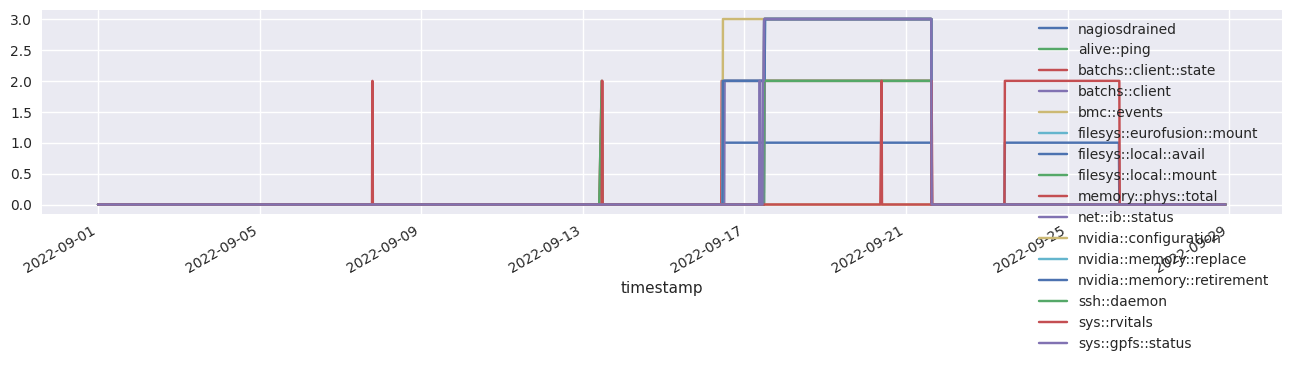

In [18]:
_, axes = plt.subplots(figsize=(16, 3))
df_nagios_rebuild.plot(x="timestamp", ax=axes)
plt.show()

In [19]:
# Save rebuilt dataframe
df_nagios_rebuild.to_csv(dataset_rebuild_path + "/nagios_rebuild_node:" + NODE_SELECTED + ".csv", index=False)

In [20]:
%reset_selective -f df_
%reset_selective -f descr
%reset_selective -f ax
%reset_selective -f is_equal_

# Ganglia Metric

In [13]:
metrics_description(plugin="ganglia")

Plugin: 'ganglia'
metric: 'Gpu2_fb_used'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu3_power_management_limit'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu1_ecc_sbe_aggregate_total'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu3_gpu_utilization'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu3_sm_app_clock'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu1_retired_pages_sbe'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu0_power_usage'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'cpu_wio'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu0_board_limit_violation'
	dtype: int32
	tags:

In [14]:
df_ganglia = client.query_plugins(plugins="ganglia", node=NODE_SELECTED).sort_values(by="timestamp", ascending=True)

df_ganglia.info()
display(df_ganglia.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 12909075 entries, 12870937 to 9892230
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   node        category           
 1   year_month  category           
 2   metric      category           
 3   value       object             
 4   timestamp   datetime64[ms, UTC]
 5   plugin      category           
dtypes: category(4), datetime64[ms, UTC](1), object(1)
memory usage: 369.4+ MB


,node,year_month,metric,value,timestamp,plugin
12870937,10,NaN,os_name,Linux,2022-09-01 00:00:01+00:00,ganglia_pub
12679733,10,NaN,boottime,1660034661.0,2022-09-01 00:00:01+00:00,ganglia_pub
12824930,10,NaN,machine_type,powerpc,2022-09-01 00:00:01+00:00,ganglia_pub
12789317,10,NaN,mem_total,329871872.0,2022-09-01 00:00:01+00:00,ganglia_pub
11270578,10,NaN,cpu_num,128.0,2022-09-01 00:00:01+00:00,ganglia_pub


In [15]:
if DISPLAY_GRAPHS:
    df_ganglia = df_ganglia[["timestamp", "value", "metric"]]

    # Divide into different categories
    ganglia_metrics_available = df_ganglia["metric"].unique()
    ganglia_metrics_dict = {
        "gpu0": [s for s in ganglia_metrics_available if s.startswith("Gpu0")],
        "gpu1": [s for s in ganglia_metrics_available if s.startswith("Gpu1")],
        "gpu2": [s for s in ganglia_metrics_available if s.startswith("Gpu2")],
        "gpu3": [s for s in ganglia_metrics_available if s.startswith("Gpu3")],
        "system": [s for s in ganglia_metrics_available if s in ["boottime", "machine_type", "os_name", "os_release"]],
        "network": [s for s in ganglia_metrics_available if s in ["bytes_in", "bytes_out", "pkts_in", "pkts_out"]],
        "cpu": [s for s in ganglia_metrics_available if s.startswith("cpu")],
        "disk": [s for s in ganglia_metrics_available if s.startswith("disk") or s in ["part_max_used"]],
        "core": [s for s in ganglia_metrics_available if s in ["gexec"]],
        "load": [s for s in ganglia_metrics_available if s.startswith("load")],
        "memory": [s for s in ganglia_metrics_available if s.startswith("mem") or s.startswith("swap")],
        "process": [s for s in ganglia_metrics_available if s.startswith("proc")],
    }

In [16]:
from sklearn.preprocessing import MinMaxScaler

if DISPLAY_GRAPHS:
    for metric_name, val in ganglia_metrics_dict.items():
        _, axes = plt.subplots(figsize=(16, 5))
        empty = True
        for met in val:
            df_metric = df_ganglia.loc[df_ganglia["metric"] == met][["timestamp", "value"]]

            # Remove metrics with unmuted values
            if (df_metric["value"] == df_metric["value"].tolist()[0]).all():
                continue

            # Remove metrics non numerical
            if ~df_metric["value"].apply(lambda x: pd.to_numeric(x, errors="coerce")).notnull().all():
                continue

            empty = False

            # Scaling for plotting
            df_metric["value"] = MinMaxScaler().fit_transform(df_metric[["value"]].astype(float))
            axes.scatter(df_metric["timestamp"], df_metric["value"], label=met)
            axes.set_title("{} - (node {})".format(metric_name, NODE_SELECTED))
            axes.set_xticks(xticks_days)
            axes.legend(loc="upper left")
            axes.tick_params(axis="x", labelrotation=45)

        if empty:
            axes.remove()
        plt.tight_layout()
        plt.show()

In [17]:
%reset_selective -f ganglia_metrics_dict
%reset_selective -f ganglia_metrics_available
%reset_selective -f df_ganglia
%reset_selective -f metric_name
%reset_selective -f val
%reset_selective -f df_metric
%reset_selective -f ax
%reset_selective -f axes

# IPMI

In [18]:
metrics_description(plugin="ipmi")

Plugin: 'ipmi'
metric: 'p1_core18_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'dimm2_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p1_core5_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'ps0_input_power'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p0_core12_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p1_power'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'gpu3_core_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'ps0_output_volta'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p0_core14_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'n

In [19]:
df_ipmi = client.query_plugins(plugins="ipmi", node=NODE_SELECTED).sort_values(by="timestamp", ascending=True)

df_ipmi.info()
display(df_ipmi.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 10547519 entries, 3146510 to 2512647
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   node        category           
 1   year_month  category           
 2   metric      category           
 3   value       Float64            
 4   timestamp   datetime64[ms, UTC]
 5   plugin      category           
dtypes: Float64(1), category(4), datetime64[ms, UTC](1)
memory usage: 311.9 MB


,node,year_month,metric,value,timestamp,plugin
3146510,10,NaN,gpu0_mem_temp,33.0,2022-09-01 00:00:00+00:00,ipmi_pub
7225737,10,NaN,p1_core15_temp,42.0,2022-09-01 00:00:00+00:00,ipmi_pub
6588083,10,NaN,p0_mem_power,18.0,2022-09-01 00:00:00+00:00,ipmi_pub
154409,10,NaN,dimm10_temp,31.0,2022-09-01 00:00:00+00:00,ipmi_pub
6870054,10,NaN,p1_core10_temp,42.0,2022-09-01 00:00:00+00:00,ipmi_pub


In [20]:
if DISPLAY_GRAPHS:
    df_ipmi = df_ipmi[["value", "metric", "timestamp"]]

    descriptions = df_ipmi["metric"].sort_values().unique()

    for descr in descriptions:
        _, axes = plt.subplots(figsize=(16, 3))
        df_ipmi_plot = df_ipmi.loc[df_ipmi["metric"] == descr][["timestamp", "value"]]
        axes.plot(df_ipmi_plot["timestamp"], df_ipmi_plot["value"])
        axes.set_title("{} - {} - (node {})".format("ipmi", descr, NODE_SELECTED))
        axes.set_xticks(xticks_days)
        axes.tick_params(axis="x", labelrotation=45)
        plt.tight_layout()
        plt.show()

In [21]:
%reset_selective -f df_ipmi
%reset_selective -f df_ipmi_plot
%reset_selective -f tags
%reset_selective -f tag
%reset_selective -f ax
%reset_selective -f axes

# Job table

In [22]:
metrics_description(plugin="job_table")

Plugin: 'job_table'
metric: 'job_info_marconi100'
	dtype: None
	tags: ['plugin', 'metric', 'year_month', 'accrue_time', 'alloc_node', 'alloc_sid', 'array_job_id', 'array_max_tasks', 'array_task_id', 'array_task_str', 'array_task_throttle', 'assoc_id', 'batch_flag', 'batch_host', 'billable_tres', 'bitflags', 'boards_per_node', 'contiguous', 'cores_per_socket', 'cpus_alloc_layout', 'cpus_allocated', 'cpus_per_task', 'cpus_per_tres', 'dependency', 'derived_ec', 'eligible_time', 'end_time', 'exc_nodes', 'exit_code', 'features', 'group_id', 'job_id', 'job_state', 'last_sched_eval', 'max_cpus', 'max_nodes', 'mem_per_cpu', 'mem_per_node', 'min_memory_cpu', 'min_memory_node', 'nice', 'nodes', 'ntasks_per_board', 'ntasks_per_core', 'ntasks_per_core_str', 'ntasks_per_node', 'ntasks_per_socket', 'ntasks_per_socket_str', 'num_cpus', 'num_nodes', 'num_tasks', 'partition', 'pn_min_cpus', 'pn_min_memory', 'pn_min_tmp_disk', 'power_flags', 'priority', 'profile', 'qos', 'reboot', 'req_nodes', 'req_swit

In [23]:
df_jobtable = (
    client.query_plugins(plugins="job_table")
    .loc[lambda df: df["nodes"].str.contains(NODE_SELECTED)]
    .sort_values("submit_time")
)

df_jobtable.info()
display(df_jobtable.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 4022 entries, 62218 to 81337
Data columns (total 92 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   start_time             4022 non-null   datetime64[ms, UTC]
 1   batch_host             0 non-null      string             
 2   sched_nodes            0 non-null      string             
 3   run_time               0 non-null      UInt32             
 4   pn_min_cpus            0 non-null      UInt32             
 5   job_id                 4022 non-null   UInt32             
 6   ntasks_per_socket_str  0 non-null      string             
 7   profile                0 non-null      UInt16             
 8   array_job_id           4022 non-null   UInt32             
 9   mem_per_node           0 non-null      boolean            
 10  exc_nodes              0 non-null      string             
 11  plugin                 4022 non-null   category         

,start_time,batch_host,sched_nodes,run_time,pn_min_cpus,job_id,ntasks_per_socket_str,profile,array_job_id,mem_per_node,...,time_min,cpus_per_tres,tres_req_str,shared,array_task_throttle,tres_per_node,time_limit,restart_cnt,job_state,run_time_str
62218,2022-09-03 02:29:25+00:00,<NA>,<NA>,<NA>,<NA>,2048434,<NA>,<NA>,2048434,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,gres:gpu:4,<NA>,<NA>,FAILED,<NA>
137213,2022-09-10 12:46:35+00:00,<NA>,<NA>,<NA>,<NA>,1259399,<NA>,<NA>,1259399,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,gres:gpu:4,<NA>,<NA>,FAILED,<NA>
169598,2022-09-16 04:42:26+00:00,<NA>,<NA>,<NA>,<NA>,5054747,<NA>,<NA>,5054747,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,gres:gpu:4,<NA>,<NA>,FAILED,<NA>
181243,2022-09-13 04:37:58+00:00,<NA>,<NA>,<NA>,<NA>,6132524,<NA>,<NA>,6132524,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,gres:gpu:4,<NA>,<NA>,FAILED,<NA>
203969,2022-09-02 03:47:04+00:00,<NA>,<NA>,<NA>,<NA>,1978696,<NA>,<NA>,1978696,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,gres:gpu:4,<NA>,<NA>,COMPLETED,<NA>


In [24]:
if DISPLAY_GRAPHS:
    df_jobtable = df_jobtable[["job_state", "start_time", "end_time"]]

    job_states = df_jobtable["job_state"].unique()

    _, ax = plt.subplots(len(job_states), figsize=(16, 10))
    for descr, axes in zip(job_states, ax.ravel()):
        df_jobtable_plot = df_jobtable.loc[df_jobtable["job_state"] == descr]
        axes.scatter(df_jobtable_plot["start_time"], df_jobtable_plot["job_state"], label="start")
        axes.scatter(df_jobtable_plot["end_time"], df_jobtable_plot["job_state"], label="end")
        axes.legend()
        axes.set_title("{}\n {}\n (node {})".format("job_state", descr, NODE_SELECTED))
        axes.set_xticks(xticks_days)
        axes.tick_params(axis="x", labelrotation=45)
    plt.tight_layout()
    plt.show()

In [25]:
%reset_selective -f df_jobtable
%reset_selective -f df_jobtable_plot
%reset_selective -f job_states
%reset_selective -f tag
%reset_selective -f ax
%reset_selective -f axes

# Logics

In [26]:
metrics_description(plugin="logics")

Plugin: 'logics'
metric: 'deviceid'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Tot'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Volt2'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Potenza_attiva'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'pit'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Corrente_L3'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Volt3'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Pue'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'ID_Modbus'
	dtype: int32
	tags: ['plugin', 'metric', 'year

In [27]:
df_logics = client.query_plugins(plugins="logics")

df_logics.info()
display(df_logics.head(5))

# Data of the position of the node w.r.t. the panel code is not available

/home/riccardo/Anomaly-Detection/query_tool/query_tool.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, table.to_pandas(**to_pandas_kwargs)], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38835580 entries, 0 to 38835579
Data columns (total 7 columns):
 #   Column      Dtype              
---  ------      -----              
 0   device      object             
 1   panel       object             
 2   year_month  category           
 3   metric      category           
 4   value       Float64            
 5   timestamp   datetime64[ms, UTC]
 6   plugin      category           
dtypes: Float64(1), category(3), datetime64[ms, UTC](1), object(2)
memory usage: 1.3+ GB


,device,panel,year_month,metric,value,timestamp,plugin
0,qe-20a-n,marconi-a3,NaN,Bad_values,1.0,2022-09-04 12:25:50+00:00,logics_pub
1,qe-20a-n,marconi-a3,NaN,Bad_values,0.0,2022-09-04 12:26:50+00:00,logics_pub
2,qe-20a-n,marconi-a3,NaN,Bad_values,1.0,2022-09-04 12:33:53+00:00,logics_pub
3,qe-20a-n,marconi-a3,NaN,Bad_values,0.0,2022-09-04 12:42:56+00:00,logics_pub
4,qe-20a-n,marconi-a3,NaN,Bad_values,1.0,2022-09-04 12:43:56+00:00,logics_pub


# Schneider

In [28]:
metrics_description(plugin="schneider")

Plugin: 'schneider'
metric: 'PLC_PLC_Q101.Min_vel_pompe'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Rif_auto_p101'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Alm_nostart_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Temp_ritorno'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.V_ore_tot_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Alm_inverter_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.T_scambio_quadri'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Manuale_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp

In [29]:
df_schneider = client.query_plugins(plugins="schneider")

df_schneider.info()
display(df_schneider.head(5))

# Data of the position of the node w.r.t. the panel code is not available

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33554432 entries, 0 to 33554431
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   panel       category           
 1   year_month  category           
 2   metric      category           
 3   value       Int32              
 4   timestamp   datetime64[ms, UTC]
 5   plugin      category           
dtypes: Int32(1), category(4), datetime64[ms, UTC](1)
memory usage: 576.0 MB


,panel,year_month,metric,value,timestamp,plugin
0,Q101,NaN,Alm_TY141,0,2022-09-23 22:00:00+00:00,schneider_pub
1,Q101,NaN,Alm_TY141,0,2022-09-23 23:00:00+00:00,schneider_pub
2,Q101,NaN,Alm_TY141,0,2022-09-02 22:00:00+00:00,schneider_pub
3,Q101,NaN,Alm_TY141,0,2022-09-02 23:00:00+00:00,schneider_pub
4,Q101,NaN,Alm_TY141,0,2022-09-03 22:00:00+00:00,schneider_pub


# Slurm 

In [30]:
metrics_description(plugin="slurm")

Plugin: 'slurm'
metric: 'total_memory_eligible'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.jobs.tot_gpus'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'qos', 'partition', 'job_state']
metric: 'cluster_cpu_util'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 'total_memory_down'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 'total_memory_config'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.jobs.nodes_eligible'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'qos', 'partition', 'job_state']
metric: 'cluster_memory_util'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.totals.total_nodes_down'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'partition']
metric: 's21.jobs.eligible_v2'
	dt

In [31]:
df_slurm = client.query_plugins(plugins="slurm")

df_slurm.info()
display(df_slurm.head(5))

# Data of the position of the node w.r.t. the partition code is not available

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59574539 entries, 0 to 59574538
Data columns (total 9 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   metric      category           
 2   value       Float64            
 3   timestamp   datetime64[ms, UTC]
 4   user_id     UInt32             
 5   plugin      category           
 6   partition   category           
 7   job_state   category           
 8   qos         category           
dtypes: Float64(1), UInt32(1), category(6), datetime64[ms, UTC](1)
memory usage: 1.6 GB


,year_month,metric,value,timestamp,user_id,plugin,partition,job_state,qos
0,NaN,job_id,1348166.0,2022-09-14 22:00:00+00:00,393,slurm_pub,1,FAILED,NaN
1,NaN,job_id,1653075.0,2022-09-07 22:00:00+00:00,366,slurm_pub,1,COMPLETED,NaN
2,NaN,job_id,1147583.0,2022-09-13 23:00:00+00:00,478,slurm_pub,1,COMPLETED,NaN
3,NaN,job_id,3995923.0,2022-09-25 23:00:00+00:00,1474,slurm_pub,1,OUT_OF_MEMORY,NaN
4,NaN,job_id,4080670.0,2022-09-04 22:00:00+00:00,1737,slurm_pub,1,COMPLETED,NaN
